# **Consigna**
Se requiere construir una regresión que nos permita predecir el valor medio de las casas en distritos de California, EEUU (medidos en cientos de miles de dólares $100,000). Este dataset se deriva del censo de 1990 de EEUU, donde cada observación es un bloque. Un bloque es la unidad geográfica más pequeña para la cual la Oficina del Censo de EEUU publica datos de muestra (un bloque típicamente tiene una población de 600 a 3000 personas).

Los atributos, en el orden en que se guardaron en el dataset, son:


*   MedInc: Ingreso medio en el bloque
*   HouseAge: Edad mediana de las casas en el bloque
*   AveRooms: Número promedio de habitaciones por hogar.
*   AveBedrms: Número promedio de dormitorios por hogar.
*   Population: Población del bloque
*   AveOccup: Número promedio de miembros por hogar.
*   Latitude: Latitud del bloque
*   Longitude: Longitud del bloque

Y el target es:

MedHouseVal: Mediana del costo de casas en el bloque (en unidades de a $100.000)

Tareas y preguntas a resolver:



1.   Obtener la correlación entre los atributos y los atributos con el target. ¿Cuál atributo tiene mayor correlación lineal con el target y cuáles atributos parecen estar más correlacionados entre sí? Se puede obtener los valores o directamente graficar usando un mapa de calor.
2.   Graficar los histogramas de los diferentes atributos y el target. ¿Qué tipo de forma de histograma se observa? ¿Se observa alguna forma de campana que nos indique que los datos pueden provenir de una distribución gaussiana, sin entrar en pruebas de hipótesis?
3.   Calcular la regresión lineal usando todos los atributos. Con el set de entrenamiento, calcular la varianza total del modelo y la que es explicada con el modelo. ¿El modelo está capturando el comportamiento del target? Expanda su respuesta.
4.   Calcular las métricas de MSE, MAE y R2 del set de evaluación.
5.   Crear una regresión de Ridge. Usando una validación cruzada de 5-folds y usando como métrica el MSE, calcular el mejor valor de α, buscando entre [0, 12.5]. Graficar el valor de MSE versus α
6.   Comparar, entre la regresión lineal y la mejor regresión de Ridge, los resultados obtenidos en el set de evaluación. ¿Cuál da mejores resultados (usando MSE y MAE)? Conjeturar por qué el mejor modelo mejora. ¿Qué error puede haberse reducido?








## Carga del dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing

# Cargar el dataset
california_housing = fetch_california_housing()
X = california_housing.data
y = california_housing.target

# Crear un DataFrame con los datos
X = pd.DataFrame(X, columns=california_housing['feature_names'])
y = pd.Series(y, name=california_housing['target_names'][0])

# Concatenar los datos en un solo DataFrame
df_california = pd.concat([X, y], axis=1)

In [10]:
print(df_california.shape)
df_california.head(10)

(20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


# 1. Matriz de correlacion y mapa de calor





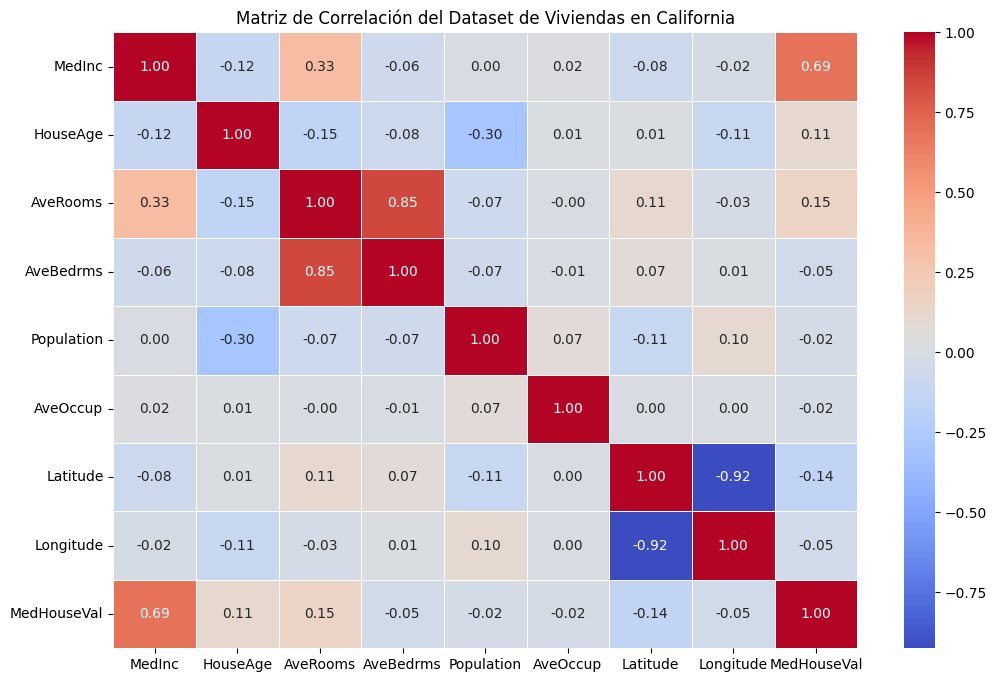

In [3]:
# Calculo de la matriz de correlacion
correlation_matrix = df_california.corr()

# Visualizacion de la matriz de correlacion
plt.figure(figsize=(12, 8))

# Crear un mapa de calor con la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matriz de Correlación del Dataset de Viviendas en California")
plt.show()



### 1. MedHouseVal
El atributo que tiene mayor correlacion con el target es *MedInc*. Esto indica que a medida que aumenta el ingreso medio, tienden a aumentar las casas en ese bloque. El resto de los atributos, no posee una relacion fuerte con el taget.

### 2. Otros atributos



*   *AveBedrms* y *AveRooms* tienen una alta correlacion entre si, esto nos dice que que a medida que un bloque de casas tiene mas habitaciones, tambien tiene mas dormitorios.
*   *Latitude* y *Longitude* poseen una alta correlacion negativa.

En este sentido para eliminar la correlación entre las features podríamos eliminar 1 de cada par que tiene alta correlación entre sí (es decir, podría ser redundante para nuestro modelo).




# 2. Histogramas

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')


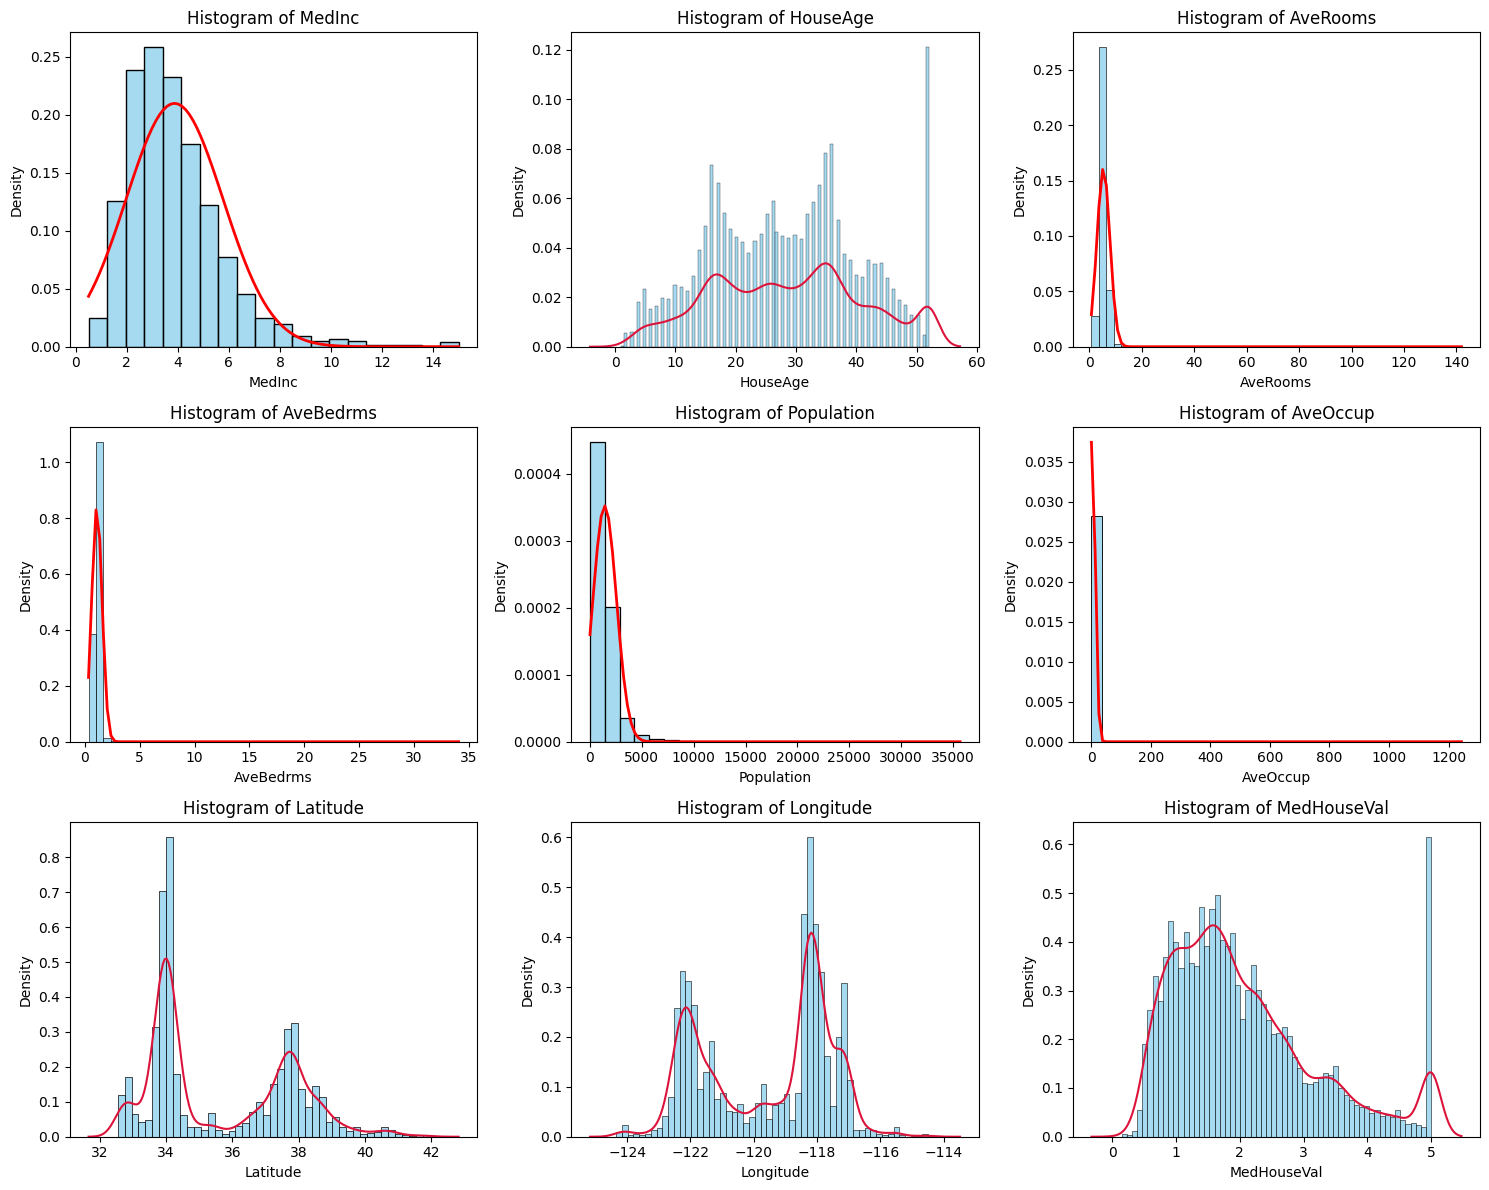

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from scipy.stats import norm
import numpy as np

# Load the California housing dataset
data = fetch_california_housing(as_frame=True)
df_california = data.frame

# Define column names for which we want to plot histograms
columns_to_plot = df_california.columns[:9]  # Selecting the first 9 columns (if more exist)

# Define the number of bins for each plot
bins_list = [20, 100, 50, 50, 25, 35, 45, 55, 60]  # Customize bins for each plot
print(columns_to_plot)
kde_columns = ['HouseAge', 'Latitude' , 'Longitude', 'MedHouseVal']

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten() 
for i, col in enumerate(columns_to_plot):
    # Plot the histogram with density
    
    sns.histplot(df_california[col], stat='density', bins=bins_list[i], kde=False, ax=axes[i], color='skyblue')
    
    if col in kde_columns:
        sns.kdeplot(df_california[col], ax=axes[i], color='crimson')
    else:
        mean = df_california[col].mean()
        std = df_california[col].std()
        
        x = np.linspace(df_california[col].min(), df_california[col].max(), 100)
        y = norm.pdf(x, mean, std)
        axes[i].plot(x, y, color='red', lw=2)
    
    # Set labels and title
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Por lo que se puede ver:
La mayoría se podría interpretar como suma de distribuciones gaussianas, en algunas es solo 1 o puede llegar a tratarse de la suma de 6 en el mismo gráfico (por ejemplo HouseAge).
Vemos que hay algunos gráficos que aparecen tipo delta de dirac, es decir tienen un pico pronunciado.
En algunos casos como AveBedrms es porque hay valores que acumulan mucha densidad de probabilidad y no nos permiten observar algunos detalles en el histograma.



# 3. Regresion Lineal

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Dividir los datos en conjuntos de entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo de regresión lineal
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predicciones en el conjunto de entrenamiento
y_train_pred = lin_reg.predict(X_train)

# Calcular varianza total y explicada
total_variance = np.var(y_train)
explained_variance = np.var(y_train_pred)
print(f"Varianza Total: {total_variance}, Varianza Explicada: {explained_variance}")


Varianza Total: 1.336778211789427, Varianza Explicada: 0.8188450862647514


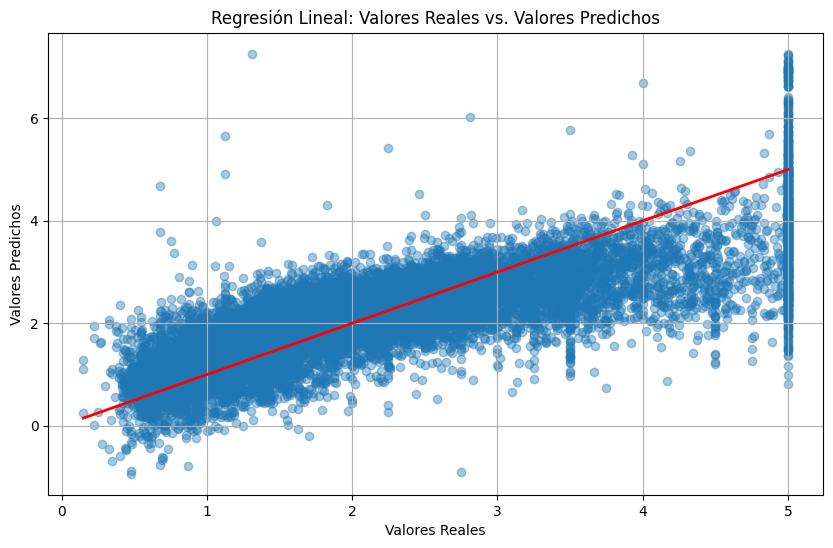

In [6]:
# Graficar los valores reales vs. los valores predichos
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, alpha=0.4)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='r', lw=2)  # Línea ideal
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Regresión Lineal: Valores Reales vs. Valores Predichos")
plt.grid(True)
plt.show()


El modelo esta capturando el comportamiento del target, pero con limitaciones. Aunque muchos puntos están relativamente cerca de la línea, hay una dispersion alta, especialmente en los valores más altos (cercanos a 5 en el eje X).

Esto puede deberse a que hay una relacion no lineal entre los atributos y el target o que puntos dispersos esten afectando al modelo.